# **Trabalho Final**
## Fernando Söndahl Brito

    DEPARTAMENTO DE ENGENHARIA DE PRODUÇÃO

    ANÁLISE DE EFICIÊNCIA PRODUTIVA

    PROFª. LÍDIA


# 1. Contexto do Problema

O mercado do futebol movimenta milhões todos os anos em transferências de jogadores entre os clubes. Além da expectativa do retorno do investimento com ações de *marketing*, novas transferências, títulos; a chegada de um novo jogador interfere na esperança e paixão dos torcedores. O sucesso da operação depende inevitavelmente do desempenho do novo jogador a vestir a camisa do clube.

Esse cenário impulsiona cada vez mais o desenvolvimento dos analistas de mercado na indústria do futebol. É fundamental nesse processo a capacidade de se avaliar os jogadores de maneira criteriosa, deixando de lado visões subjetivas e clubistas. Portanto, a análise envoltória de dados (DEA) apresenta-se como um método capaz de ponderar o desempenho dos atletas pelo o que realmente têm produzido dentro de campo.

Buscando aplicar o método, foi simulado um processo de sondagem do mercado brasileiro em busca de seus principais atacantes. Imaginando a situação de um clube que busca investir na própria produção de gols, avaliou-se dentre os artilheiros do Campeonato Brasileiro aqueles com maior eficiência, classificando os como candidatos à vaga.

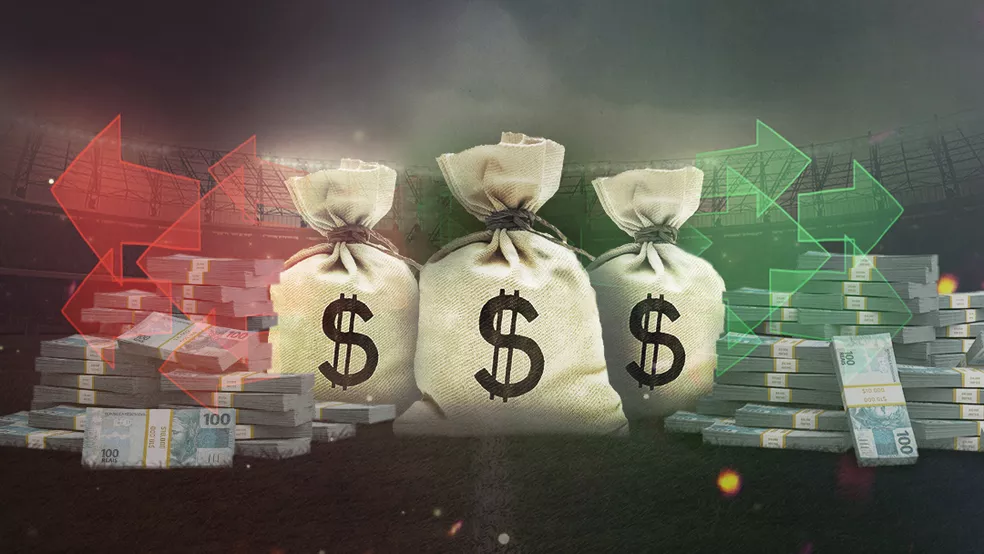

# 2. Pacotes e Bibliotecas

In [ ]:
!apt-get install -y -qq glpk-utils
!pip install -q pyomo

In [3]:
import pandas as pd
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np

pd.options.mode.chained_assignment = None

# 3. Dados do problema

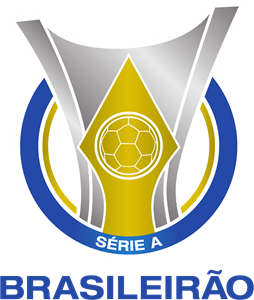

O objetivo dessa caso é analisar dentro os principais artilheiros do Campeonato Brasileiro série A, aqueles com o melhor desempenho no campeonato.

Como *input's* foram utilizados os seguintes dados:

1.   Minutos jogados;
2.   Finalizações.

Buscando avaliar como os jogadores aproveitam as oportunidades, tanto em tempo quanto em chances de marcar durante o jogo. Concretizam-se as oportunidades através dos seguintes *output's*:

1.   Gols com bola rolando;
2.   Gols de pênalti;
3.   Assistências.



In [56]:
dados_df = pd.read_excel(io="https://github.com/fersondahl-uff/DEA/raw/main/Artilheiros%20Brasileiro.xlsx", sheet_name='DMU serie A', header=1)
dados_df

,Jogador,Minutos jogados,Finalizações,Gols de bola rolando,Gols de Penalti,Assistências
0,Cano,1170,47,9,0,0
1,Calleri,1275,48,8,1,1
2,Hulk,1080,42,6,1,2
3,Rony,1095,36,7,0,0
4,Bissoli,1050,34,3,4,0
5,Pedro Raul,988,29,6,1,0
6,Mendoza,858,34,7,0,0
7,Marcos Leonardo,988,35,6,0,1
8,Erison,1040,38,5,1,1
9,Luciano,720,28,3,2,0


#4. Modelo se resolução

Para a resolução do problema, foi escolhido o método CCR orientado à *output's*. Para proteger o equilíbrio do estudo, os dados coletados foram retirados exclusivamente da principal competição nacional, sendo essa uma das mais equilibradas do mundo. A partir disso, e além das próprias características do esporte, é possível imaginar que os jogadores tenham a mesma capacidade de aproveitar cada oportunidade recebida para marcar, fazendo com que seja lógico avaliar o problema sob a ótica de retornos constantes de escala.

Além disso, foram utilizadas restrições ao pesos dos *output's* para defender uma estrutura hierárquica lógica. Gols com a bola rolando devem receber um peso maior em relação à gols de pênalti; os gols serão sempre mais valorizados em relação à assistências.

**Exemplo do modelo de resolução para a DMU HULK**

    min 1080*inputs[0] + 42*inputs[1]
   
    st
    
    6*u[0] + u[1] + 2*u[2] = 1
    
    9*u[0] - (1170*inputs[0] + 47*inputs[1]) <= 0

    8*u[0] + u[1] + u[2] - (1275*inputs[0] + 48*inputs[1]) <= 0
    6*u[0] + u[1] + 2*u[2] - (1080*inputs[0] + 42*inputs[1]) <= 0
    7*u[0] - (1095*inputs[0] + 36*inputs[1]) <= 0
    3*u[0] + 4*u[1] - (1050*inputs[0] + 34*inputs[1]) <= 0
    6*u[0] + u[1] - (988*inputs[0] + 29*inputs[1]) <= 0
    7*u[0] - (858*inputs[0] + 34*inputs[1]) <= 0
    6*u[0] + u[2] - (988*inputs[0] + 35*inputs[1]) <= 0
    5*u[0] + u[1] + u[2] - (1040*inputs[0] + 38*inputs[1]) <= 0
    3*u[0] + 2*u[1] - (720*inputs[0] + 28*inputs[1]) <= 0
    3*u[0] + 2*u[1] - (750*inputs[0] + 21*inputs[1]) <= 0
    5*u[0] - (1078*inputs[0] + 32*inputs[1]) <= 0

    u[0] >= u[1]
    u[1] >= u[2]

In [62]:
## MODELO CCR MULTIPLICADORES ORIENTADO À OUTPUT
dados_df.rename(columns={"Jogador": "DMU",
                                          'Minutos jogados': 'Input 1', 'Finalizações': 'Input 2', 'Gols de bola rolando': 'Output 1',
       'Gols de Penalti': 'Output 2', 'Assistências': 'Output 3'}, inplace=True)

dmus = range(len(dados_df))

n_input = range(len(list(filter(lambda linha: "Input" in linha ,list(dados_df.columns)))))
n_output = range(len(list(filter(lambda linha: "Output" in linha ,list(dados_df.columns)))))

resultado = {"DMU": [], "eficiencia %": []}

for j in n_input:
  resultado.update({f"v{j+1}": []})

for i in n_output:
  resultado.update({f"u{i+1}": []})


for problem in dmus:
    
    
    model = pyo.ConcreteModel()
    
    model.inputs = pyo.Var(n_input, bounds=(0, np.inf))
    model.u = pyo.Var(n_output,bounds=(0, np.inf))
    u = model.u
    
    inputs = model.inputs
    
    model.C1 = pyo.Constraint(expr = sum(dados_df[f'Output {i+1}'][problem]*u[i] for i in n_output)  == 1)
    
    model.C2 = pyo.ConstraintList()
    for dmu in dmus:
        model.C2.add(expr= sum(dados_df[f'Output {i+1}'][dmu]*u[i] for i in n_output) - (sum(dados_df[f'Input {j+1}'][dmu]*inputs[j] for j in n_input)) <= 0)

    model.C3 = pyo.Constraint(expr = u[0] >= u[1])
    model.C4 = pyo.Constraint(expr = u[1] >= u[2])

    model.obj = pyo.Objective(expr= sum(dados_df[f'Input {j+1}'][problem]*inputs[j] for j in n_input), sense=minimize)

    opt = SolverFactory('glpk')
    opt.solve(model)

    for j in n_input:
      resultado[f'v{j+1}'].append(pyo.value(inputs[j]))
    for i in n_output:
      resultado[f'u{i+1}'].append(pyo.value(u[i]))
    
    resultado['DMU'] = dados_df['DMU']
    resultado['eficiencia %'].append(round(100/pyo.value(model.obj), 2))
    

resultado_mult_output = pd.DataFrame(data=resultado).set_index('DMU')

resultado_mult_output['status'] = np.where(resultado_mult_output['eficiencia %'] == 100, 'Eficiente', 'Ineficiente')

qtd_eficientes = len(resultado_mult_output.query('status == "Eficiente"'))

print(f"Tabela com os resultados do método dos Multilplicadores (Orientação: Output) - {qtd_eficientes} eficientes")
resultado_mult_output.sort_values('eficiencia %', ascending=False).reset_index()

Tabela com os resultados do método dos Multilplicadores (Orientação: Output) - 3 eficientes


,DMU,eficiencia %,v1,v2,u1,u2,u3,status
0,Hulk,100.00,0.000360,0.014544,0.111111,0.111111,0.111111,Eficiente
1,Pedro Raul,100.00,0.000574,0.014925,0.142857,0.142857,0.000000,Eficiente
2,Mendoza,100.00,0.000016,0.028998,0.142857,0.000000,0.000000,Eficiente
3,Léo Gamalho,98.64,0.000000,0.048276,0.200000,0.200000,0.000000,Ineficiente
4,Calleri,97.29,0.000407,0.010592,0.101379,0.101379,0.087587,Ineficiente
5,Cano,94.29,0.000907,0.000000,0.111111,0.000000,0.000000,Ineficiente
6,Rony,94.17,0.000016,0.028998,0.142857,0.000000,0.000000,Ineficiente
7,Marcos Leonardo,91.01,0.000529,0.016455,0.144784,0.131299,0.131299,Ineficiente
8,Bissoli,90.07,0.000574,0.014925,0.142857,0.142857,0.000000,Ineficiente
9,Luciano,85.93,0.000804,0.020896,0.200000,0.200000,0.000000,Ineficiente
